In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Define filepath
filepath = 'C:/Users/mengj/OneDrive - lamar.edu/LectureNote2023/MLforCivilEng/TeamProject2/WoodbineData_label2.xlsx'

df = pd.read_excel(filepath)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      268 non-null    int64  
 1   StateWellN      268 non-null    int64  
 2   StateWel_1      268 non-null    int64  
 3   LatitudeDD      268 non-null    float64
 4   Dlat            268 non-null    int64  
 5   Mlat            268 non-null    int64  
 6   Slat            268 non-null    float64
 7   LongitudeD      268 non-null    float64
 8   Dlong           268 non-null    int64  
 9   Mlong           268 non-null    int64  
 10  Slong           268 non-null    float64
 11  TDS_mg/L        268 non-null    float64
 12  WellDepth       268 non-null    int64  
 13  SAR             268 non-null    float64
 14  Hardness_mg/L   268 non-null    float64
 15  Calcium_mg/L    268 non-null    float64
 16  Magnesium_mg/L  268 non-null    float64
 17  Sulfate_mg/L    268 non-null    flo

## use all variables

In [6]:
# set X, y
X = df[df.columns[11:26]]
X.drop(['Fluoride_mg/L','Texture_SSURGO'], axis=1, inplace=True)
print(X.columns)
y = df['label']

Index(['TDS_mg/L', 'WellDepth', 'SAR', 'Hardness_mg/L', 'Calcium_mg/L',
       'Magnesium_mg/L', 'Sulfate_mg/L', 'Chloride_mg/L', 'pH', 'Texture_Num',
       'Clay_SSURGO', 'SAR_SSURGO', 'EC_SSURGO'],
      dtype='object')


C:\Users\mengj\AppData\Local\Temp\ipykernel_5656\974104129.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['Fluoride_mg/L','Texture_SSURGO'], axis=1, inplace=True)


In [7]:
# feature scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((0,1))
X_scaled = scaler.fit_transform(X)
X_scaled

array([[0.07073126, 0.35879144, 0.21118793, ..., 0.75609756, 0.14285714,
        1.        ],
       [0.11776263, 0.43096937, 0.24245757, ..., 0.75609756, 0.14285714,
        1.        ],
       [0.0319273 , 0.42173731, 0.21280417, ..., 0.75609756, 0.14285714,
        1.        ],
       ...,
       [0.08571253, 0.07679396, 0.18622609, ..., 0.02439024, 0.        ,
        0.        ],
       [0.05771474, 0.05916911, 0.03133698, ..., 0.02439024, 0.        ,
        0.        ],
       [0.12334991, 0.07679396, 0.11432612, ..., 0.02439024, 0.        ,
        0.        ]])

In [8]:
# split training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [9]:
print(len(X_train), len(X_test))

187 81


In [10]:
print(y_train)

242    1
190    1
142    0
125    0
192    0
      ..
20     1
188    0
71     0
106    0
102    0
Name: label, Length: 187, dtype: int64


In [11]:
print(y_test)

115    0
213    0
22     1
132    0
117    1
      ..
101    0
193    0
38     0
257    0
109    0
Name: label, Length: 81, dtype: int64


## Multinomial Naive Bayes classifier

In [12]:
from sklearn.naive_bayes import MultinomialNB

# try default hyperparameters
model = MultinomialNB()

In [13]:
model.get_params(deep=True)

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In sklearn API the model has four parameters: alpha, force_alpha, fit_prior, class_prior.
But when we set them there is an error said "force_alpha" parameter should not be put in this model.

In [14]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Evaluate the performance of the model

In [15]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [16]:
# accuracy score
accur = accuracy_score(y_pred, y_test)
print(accur)

0.7777777777777778


In [17]:
f1 = f1_score(y_pred, y_test, average="weighted")
print(f1)

0.8544011544011544


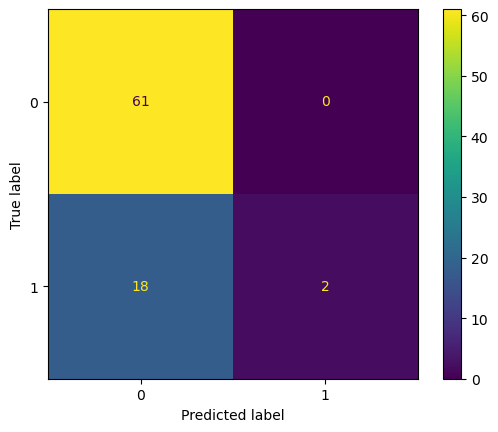

In [18]:
# The confusion matrix
labels = [0,1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot();

## Optimize NBC model with optuma

In [19]:
import optuna

In [20]:
# define objective function
def objective(trial):
    # select hyperparameters to optimize
    alpha = trial.suggest_float("alpha", 0.0, 200.0)
    fit_prior = trial.suggest_categorical("fit_prior", [True, False])

    # build the model
    model = MultinomialNB(alpha=alpha, fit_prior=fit_prior, class_prior=None)

    # train the model
    model.fit(X_train, y_train)

    # Evaluate how good it is on the test set
    y_pred = model.predict(X_test)
    accur = accuracy_score(y_pred, y_test)
    #f1 = f1_score(y_pred, y_test, average="weighted")

    return accur if accur != np.nan else float("inf")

# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# optimize hyperparameters by maximize the accuracy on the test set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1, callbacks=[print_callback])

[I 2023-03-10 20:41:43,177] A new study created in memory with name: no-name-a2488454-64bd-4a34-952c-90ae38230ebb
[I 2023-03-10 20:41:43,196] Trial 0 finished with value: 0.7530864197530864 and parameters: {'alpha': 108.82163156761457, 'fit_prior': True}. Best is trial 0 with value: 0.7530864197530864.


Current value: 0.7530864197530864, Current params: {'alpha': 108.82163156761457, 'fit_prior': True}
Best value: 0.7530864197530864, Best params: {'alpha': 108.82163156761457, 'fit_prior': True}


In [21]:
model_opti = MultinomialNB(alpha=137.12038496485422, fit_prior=True, class_prior=None)
model_opti.fit(X_train, y_train)
y_pred_opti = model.predict(X_test)

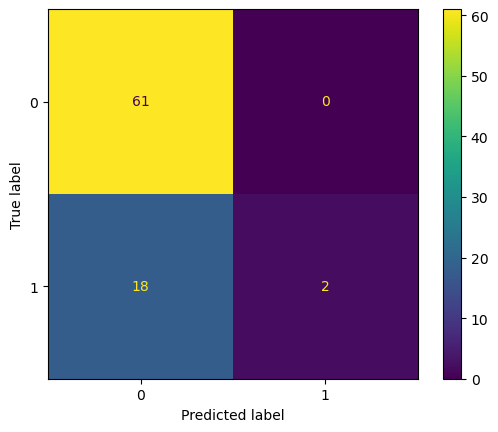

In [22]:
# The confusion matrix
labels = [0,1]
cm = confusion_matrix(y_test, y_pred_opti, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

## select variables according to MI

In [23]:
# set X, y
X = df[['TDS_mg/L','WellDepth','SAR','Hardness_mg/L','Sulfate_mg/L','Chloride_mg/L','EC_SSURGO']]
y = df['label']

# feature scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((0,1))
X_scaled = scaler.fit_transform(X)

# split training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [24]:
# try default hyperparameters
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [25]:
# accuracy score
accur = accuracy_score(y_pred, y_test)
print(accur)

0.7654320987654321


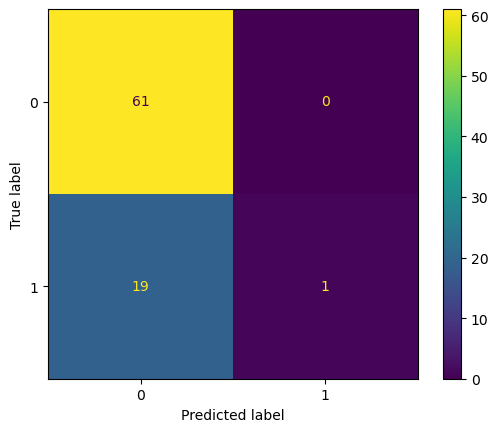

In [26]:
# The confusion matrix
labels = [0,1]
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

In [29]:
# define objective function
def objective(trial):
    # select hyperparameters to optimize
    alpha = trial.suggest_float("alpha", 0.0, 200.0)
    fit_prior = trial.suggest_categorical("fit_prior", [True, False])

    # build the model
    model = MultinomialNB(alpha=alpha, fit_prior=fit_prior, class_prior=None)

    # train the model
    model.fit(X_train, y_train)

    # Evaluate how good it is on the test set
    y_pred = model.predict(X_test)
    accur = accuracy_score(y_pred, y_test)
    #f1 = f1_score(y_pred, y_test, average="weighted")

    return accur if accur != np.nan else float("inf")

# for convenience, print some optimization trials information
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# optimize hyperparameters by maximize the accuracy on the test set
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1, callbacks=[print_callback])

[I 2023-03-10 20:45:34,845] A new study created in memory with name: no-name-fd2b123e-65fa-49a4-8601-d4c7ad26262f
[I 2023-03-10 20:45:34,871] Trial 0 finished with value: 0.6790123456790124 and parameters: {'alpha': 171.51137943498668, 'fit_prior': False}. Best is trial 0 with value: 0.6790123456790124.


Current value: 0.6790123456790124, Current params: {'alpha': 171.51137943498668, 'fit_prior': False}
Best value: 0.6790123456790124, Best params: {'alpha': 171.51137943498668, 'fit_prior': False}


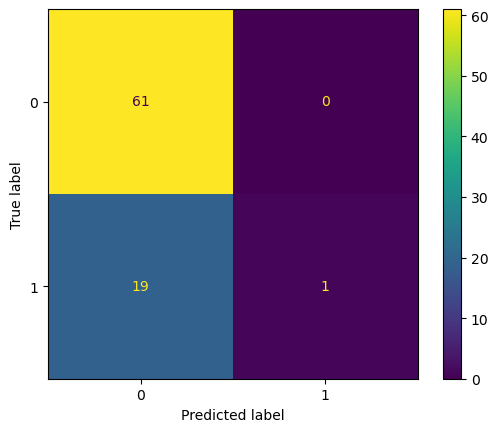

In [30]:
model_opti = MultinomialNB(alpha=171.51137943498668, fit_prior=False, class_prior=None)
model_opti.fit(X_train, y_train)
y_pred_opti = model.predict(X_test)
# The confusion matrix
labels = [0,1]
cm = confusion_matrix(y_test, y_pred_opti, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()